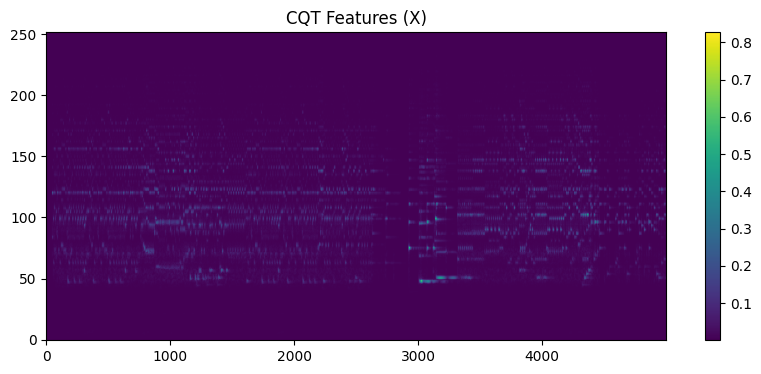

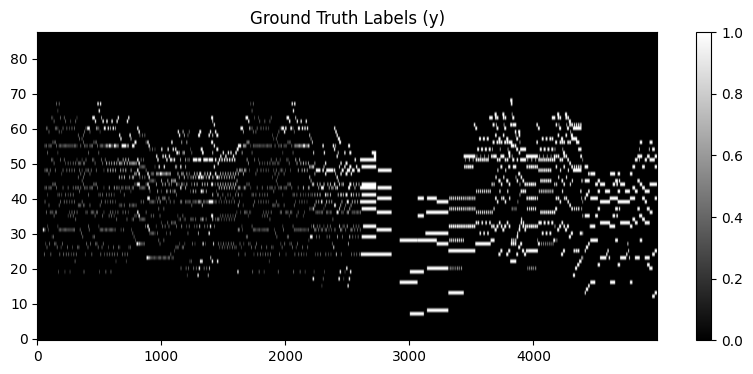

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Load a sample of X and y
X_sample = np.load('/root/dev/data/paper_split/test_set1/0_X.npy')
y_sample = np.load('/root/dev/data/paper_split/test_set1/0_y.npy')

# Plot the CQT features
plt.figure(figsize=(10, 4))
plt.title("CQT Features (X)")
plt.imshow(X_sample.T, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar()
plt.show()

# Plot the labels (piano roll)
plt.figure(figsize=(10, 4))
plt.title("Ground Truth Labels (y)")
plt.imshow(y_sample.T, aspect='auto', origin='lower', cmap='gray')
plt.colorbar()
plt.show()


In [48]:
import numpy as np
import pretty_midi
import tensorflow as tf

def predict_and_save_midi(model_path, test_file, output_midi_path):
    """
    Loads a model, predicts from a test file, and saves the output as a MIDI file.

    Args:
    - model_path: Path to the saved model (in .h5 or other supported format).
    - test_file: Path to the preprocessed test file (e.g., X.npy file).
    - output_midi_path: Path to save the resulting MIDI file.
    """

    # Load the model
    model = tf.keras.models.load_model(model_path)

    # Load the preprocessed test data (CQT features)
    X_test = np.load(test_file)

    # Predict using the model
    predictions = model.predict(X_test)

    # Post-process the predictions (apply a threshold to get binary output)
    threshold = 0.5  # You can adjust this based on model output
    predicted_pitches = (predictions > threshold).astype(np.int8)

    # Convert predictions to MIDI format
    midi = pretty_midi.PrettyMIDI()

    # Create an instrument (e.g., piano)
    instrument = pretty_midi.Instrument(program=0)  # Acoustic Grand Piano

    # Convert predictions to MIDI notes
    time_per_frame = 0.032  # Assumes 32ms per frame (adjust based on your CQT hop size)

    for time_idx, frame in enumerate(predicted_pitches):
        for pitch_idx, is_played in enumerate(frame):
            if is_played:  # If the model predicts this pitch is played
                # MIDI note range is 21 to 108 (corresponding to piano keys)
                pitch = pitch_idx + 21
                start_time = time_idx * time_per_frame
                end_time = start_time + time_per_frame  # Short note duration
                note = pretty_midi.Note(velocity=100, pitch=pitch, start=start_time, end=end_time)
                instrument.notes.append(note)

    # Add the instrument to the MIDI file
    midi.instruments.append(instrument)

    # Write to a MIDI file
    midi.write(output_midi_path)

    print(f"MIDI file saved to: {output_midi_path}")


In [49]:
from keras.models import load_model

model_path = '/root/dev/Deep-Neural-Networks-for-Piano-Music-Transcription/Saved_weights/DNN_3L/weights.hdf5'
model = load_model(model_path)
model.summary()

predict_and_save_midi(model_path=model_path, test_file='/root/dev/data/paper_split/test_set1/0_X.npy', output_midi_path='./results/output.mid')


Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 256)               64768     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 88)              

In [50]:
import numpy as np
import os

# Function to calculate min, max, and mean
def compute_normalization_values(npy_files):
    min_X, max_X, mean_X = [], [], []
    total_length = 0

    for npy_file in npy_files:
        X = np.load(npy_file)
        min_X.append(X.min())
        max_X.append(X.max())
        mean_X.append(X.sum(axis=0))
        total_length += X.shape[0]  # Accumulate total number of frames

    global_min = min(min_X)
    global_max = max(max_X)
    global_mean = np.sum(mean_X, axis=0) / total_length

    return global_mean, global_min, global_max

# Load all npy files from a directory
def load_npy_files_from_folder(folder_path):
    npy_files = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith('_X.npy'):  # Look for feature files
            npy_files.append(os.path.join(folder_path, file_name))
    return npy_files

# Folders where your data is stored
train_folder = '/root/dev/data/processed_split/train'
val_folder = '/root/dev/data/processed_split/val'
test_folder = '/root/dev/data/processed_split/test'

# Load train files only for training set normalization
train_files = load_npy_files_from_folder(train_folder)

# Load all files for complete dataset normalization
all_files = train_files + load_npy_files_from_folder(val_folder) + load_npy_files_from_folder(test_folder)

# Compute normalization for training set
train_mean, train_min, train_max = compute_normalization_values(train_files)
print("Training Set Normalization:")
print(f"Mean: {train_mean}\nMin: {train_min}\nMax: {train_max}\n")

# Compute normalization for whole dataset
dataset_mean, dataset_min, dataset_max = compute_normalization_values(all_files)
print("Complete Dataset Normalization:")
print(f"Mean: {dataset_mean}\nMin: {dataset_min}\nMax: {dataset_max}\n")


Training Set Normalization:
Mean: [1.97083280e-04 1.84916388e-04 1.98644461e-04 2.05688267e-04
 2.03598341e-04 2.26006726e-04 2.42064542e-04 2.22010252e-04
 1.94079684e-04 1.87633173e-04 2.01835650e-04 2.27564834e-04
 2.49082448e-04 2.36134203e-04 2.79452396e-04 3.38324014e-04
 3.12295906e-04 2.52108097e-04 2.21453749e-04 2.04299972e-04
 2.40160405e-04 2.80174772e-04 2.47715469e-04 2.50220490e-04
 2.67376955e-04 2.75636410e-04 2.94703472e-04 3.15959310e-04
 3.40368049e-04 4.42795468e-04 5.58211335e-04 5.64190952e-04
 5.19653390e-04 4.65727057e-04 4.26295112e-04 5.56647484e-04
 6.72103076e-04 6.22446203e-04 7.00050929e-04 7.94817734e-04
 7.88852291e-04 9.56092987e-04 1.09389775e-03 1.09340280e-03
 1.50058501e-03 1.94190407e-03 1.81316337e-03 2.38046623e-03
 2.77106436e-03 2.23446964e-03 2.58140249e-03 2.64750081e-03
 1.92420713e-03 2.01467867e-03 2.26317958e-03 2.32737012e-03
 3.71150051e-03 4.28952803e-03 3.26595297e-03 3.51951131e-03
 3.72237229e-03 2.84374737e-03 2.91290845e-03 3.302

In [51]:
def post_process_predictions(predictions):
    """
    Applies post-processing to the predictions to smooth them.
    """
    for a in range(predictions.shape[1]):
        for j in range(2, predictions.shape[0] - 3):
            if predictions[j-1, a] == 1 and predictions[j, a] == 0 and predictions[j+1, a] == 0 and predictions[j+2, a] == 1:
                predictions[j, a] = 1
                predictions[j+1, a] = 1
            if predictions[j-2, a] == 0 and predictions[j-1, a] == 0 and predictions[j, a] == 1 and predictions[j+1, a] == 1 and predictions[j+2, a] == 0 and predictions[j+3, a] == 0:
                predictions[j, a] = 0
                predictions[j+1, a] = 0
            if predictions[j-1, a] == 0 and predictions[j, a] == 1 and predictions[j+1, a] == 0 and predictions[j+2, a] == 0:
                predictions[j, a] = 0
            if predictions[j-1, a] == 1 and predictions[j, a] == 0 and predictions[j+1, a] == 1 and predictions[j+2, a] == 1:
                predictions[j, a] = 1
    return predictions


In [52]:
def post_process_predictions2(predictions, smooth_window=3):
    """
    Applies smoothing to the model's predictions.

    Args:
    - predictions: The raw predictions matrix from the model.
    - smooth_window: The window size for smoothing the predictions.

    Returns:
    - A smoothed predictions matrix.
    """
    for a in range(predictions.shape[1]):  # Iterate over each pitch
        for j in range(smooth_window, predictions.shape[0] - smooth_window):
            # Case 1: If there's a gap of 0s between 1s, fill the gap
            if predictions[j-1, a] == 1 and np.all(predictions[j:j+smooth_window, a] == 0) and predictions[j+smooth_window, a] == 1:
                predictions[j:j+smooth_window, a] = 1

            # Case 2: If there's a short burst of 1s surrounded by 0s, remove it
            if np.all(predictions[j-smooth_window:j, a] == 0) and np.all(predictions[j:j+smooth_window, a] == 1) and np.all(predictions[j+smooth_window:j+(2*smooth_window), a] == 0):
                predictions[j:j+smooth_window, a] = 0

            # Case 3: Additional smoothing for very short bursts
            if np.all(predictions[j-smooth_window:j, a] == 0) and predictions[j, a] == 1 and np.all(predictions[j+1:j+smooth_window, a] == 0):
                predictions[j, a] = 0

    return predictions


In [58]:
import numpy as np
import pretty_midi
import tensorflow as tf
import librosa

def predict_from_audio_and_save_midi(model_path, audio_file, output_midi_path, min_train, max_train, sr=16000, hop_length=512, n_bins=252, bins_per_octave=36):
    """
    Loads an audio file, extracts CQT features, normalizes them, makes predictions using the model,
    applies post-processing to smooth predictions, and saves the output as a MIDI file.

    Args:
    - model_path: Path to the saved model (in .h5 or other supported format).
    - audio_file: Path to the original audio file (.wav).
    - output_midi_path: Path to save the resulting MIDI file.
    - min_train, max_train, train_mean: Normalization parameters.
    - sr: Target sample rate for the audio.
    - hop_length: Hop length for CQT (512 samples is a common default).
    - n_bins: Total number of CQT bins (default 252 for 7 octaves).
    - bins_per_octave: Number of bins per octave (default 36).
    """

    # Load the model
    model = tf.keras.models.load_model(model_path)

    # Load and process the audio
    y, sr_orig = librosa.load(audio_file, sr=sr, mono=True)

    # Compute CQT
    cqt_features = np.abs(librosa.cqt(y, sr=sr, hop_length=hop_length, n_bins=n_bins, bins_per_octave=bins_per_octave)).T

    # Normalize the CQT features
    cqt_features = (cqt_features - min_train) / (max_train - min_train)  # Min-max normalization to [0, 1]

    # Reshape input to make it compatible with the model's expected input shape
    # The model likely expects input of shape (batch_size, num_features)
    # In this case, batch_size is the number of frames, and num_features is 252
    # So we pass the entire cqt_features as one batch to the model
    predictions = model.predict(cqt_features)

    # Post-process the predictions (apply a threshold to get binary output)
    threshold = 0.5  # Adjust this threshold if necessary
    predicted_pitches = (predictions > threshold).astype(np.int8)

    # Apply post-processing to smooth the predictions
    smoothed_predictions = post_process_predictions2(predicted_pitches, smooth_window=1000)

    # Convert smoothed predictions to MIDI format
    midi = pretty_midi.PrettyMIDI()

    # Create an instrument (e.g., piano)
    instrument = pretty_midi.Instrument(program=0)  # Acoustic Grand Piano

    # Convert predictions to MIDI notes
    time_per_frame = hop_length / float(sr)  # Time duration of each frame

    for time_idx, frame in enumerate(smoothed_predictions):
        for pitch_idx, is_played in enumerate(frame):
            if is_played:  # If the model predicts this pitch is played
                pitch = pitch_idx + 21  # MIDI note range from 21 (A0) to 108 (C8)
                start_time = time_idx * time_per_frame
                end_time = start_time + time_per_frame  # Short note duration
                note = pretty_midi.Note(velocity=100, pitch=pitch, start=start_time, end=end_time)
                instrument.notes.append(note)

    # Add the instrument to the MIDI file
    midi.instruments.append(instrument)

    # Write to a MIDI file
    midi.write(output_midi_path)

    print(f"MIDI file saved to: {output_midi_path}")

train_mean = np.load("/root/dev/data/paper_split/normalization_train_mean.npy")
train_min = np.load("/root/dev/data/paper_split/normalization_min_train.npy")
train_max = np.load("/root/dev/data/paper_split/normalization_max_train.npy")
# Example usage:
predict_from_audio_and_save_midi(
    model_path="/root/dev/Deep-Neural-Networks-for-Piano-Music-Transcription/Saved_weights/DNN_3L/weights.hdf5",
    audio_file="/root/dev/data/audio/MAPS_MUS-chpn_op10_e01_AkPnCGdD.wav",
    output_midi_path="./results/output_file.mid",
    min_train=train_min,  # Replace with actual min_train value
    max_train=train_max,  # Replace with actual max_train value
    # Replace with your actual train_mean array
)


111/111 [==============================] - 2s 16ms/step
MIDI file saved to: ./results/output_file.mid
